# 05 Using a drive cycle

PyBaMM provides a number of example drive cycles that define the instantaneous current which can be read in from csv files. So we first change our current directory to the PyBaMM root directory in order to read it in.

In [1]:
try:
    import liionpack as lp
except:
    !pip install -q git+https://github.com/pybamm-team/liionpack.git@main
    import liionpack as lp
import pybamm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
pybamm.root_dir()

'/usr/local/Caskroom/miniforge/base/envs/lipack/lib/python3.9/site-packages'

In [4]:
# import drive cycle from file
drive_cycle = pd.read_csv(
    pybamm.root_dir() + "/pybamm/input/drive_cycles/US06.csv", comment="#", header=None
).to_numpy()

Let's have a look at the drive cycle. The first column is the time stamp and the second is the current.

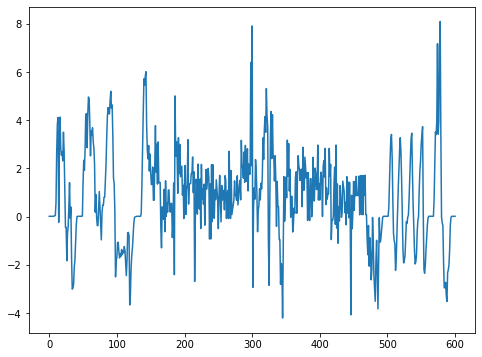

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(drive_cycle[:, 0], drive_cycle[:, 1])

We can load an experiment using the drive cycle and give it a dictionary key and an operating condition to run it. N.B this is a new feature for PyBaMM and syntax may change so please consult the documentation and make sure you have the latest version of PyBaMM.

In [6]:
experiment = pybamm.Experiment(
    operating_conditions=["Run US06 (A)"],
    drive_cycles={"US06": drive_cycle},
    period="1 second",
)

Set up our pack using our chemistry of interest.

In [7]:
netlist = lp.setup_circuit(Np=4, Ns=1, Rb=1e-4, Rc=1e-3, Ri=5e-2, V=4.0, I=1.0)

In [8]:
# Heat transfer coefficients
htc = np.ones(4) * 10
# PyBaMM parameters
chemistry = pybamm.parameter_sets.Chen2020
parameter_values = pybamm.ParameterValues(chemistry=chemistry)

In [9]:
# Solve pack
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    initial_soc=0.75,
)

Stepping simulation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 601/601 [00:02<00:00, 226.61it/s]


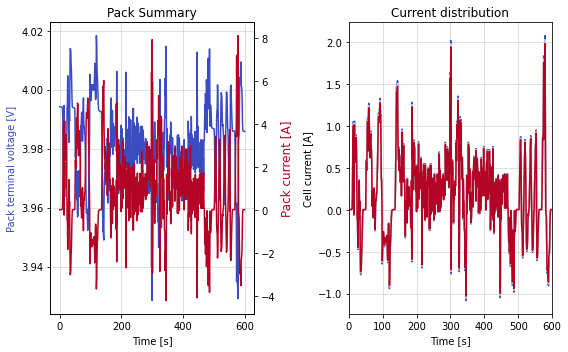

In [14]:
fig, axes = plt.subplots(1,2,tight_layout=True,figsize=(8,5))

# Get pack level results
time = output["Time [s]"]
v_pack = output["Pack terminal voltage [V]"]
i_pack = output["Pack current [A]"]

context="light"
context = lp.lp_context(context)
cmap = lp.lp_cmap(context)

colors = cmap(np.linspace(0, 1, 2))
n = output["Cell current [A]"].shape[-1]
colors_n = cmap(np.linspace(0, 1, n))

with plt.rc_context(context):
    ax = axes[0]
    # Plot pack voltage and current
    ax.plot(time, v_pack, color=colors[0], label="simulation")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Pack terminal voltage [V]", color=colors[0])
    ax.grid(False)
    ax2 = ax.twinx()
    ax2.plot(time, i_pack, color=colors[1], label="simulation")
    ax2.set_ylabel("Pack current [A]", color=colors[1])
    ax2.set_title("Pack Summary")
    ax.grid(alpha=0.5)
    
    ax = axes[1]
    for i in range(n):
        ax.plot(time, output["Cell current [A]"][:, i], color=colors_n[i])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Cell current [A]")
    ax.ticklabel_format(axis="y", scilimits=[-5, 5])
    ax.set_xlim([0,time[-1]])
    ax.grid(alpha=0.5)
    ax.set_title("Current distribution")
        
    fig.savefig("../figures/drive_cycle.pdf")